# Exploration.09 - 폐렴 진단하기

- 의료 영상 분석의 특징
    - 의료 영상 이미지는 개인 정보 보호 등의 이슈로 인해 데이터를 구하는 것이 쉽지 않음
    - 레이블링 작업 자체가 전문적 지식을 요하므로 데이터셋 구축 비용이 비쌈
    - 희귀질병을 다루는 경우 데이터를 입수하는 것 자체가 어려움
    - 음성/양성 데이터 간 imbalance가 심함 (학습에 주의 필요)
    - 이미지만으로 진단이 쉽지 않아 다른 데이터와 결합해서 해석해야 할 수도 있음

- 이번 exploration에서는 x-ray로 찍은 흉부 사진을 학습시켜 폐렴을 진단하는 모델을 만들 예정
![폐렴사진](https://d3s0tskafalll9.cloudfront.net/media/original_images/01.png)
    - 폐는 공기로 차있어서 검은색으로 나타남

## import Package

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings(action='ignore')

from tensorflow.keras.callbacks import EarlyStopping

## 데이터 불러오기

In [2]:
# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- train폴더에는 5216개의 데이터가 있는 반면에 val폴더에는 16개의 데이터밖에 없음
- 두 폴더를 적절하게 섞어서 학습을 진행할 필요가 있음

## train 데이터와 validation 데이터 재분배

### 1. train데이터와 validation데이터 합치기

In [3]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

### 2. train데이터와 validation데이터 분배하기

In [4]:
# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train데이터 변화 : 5,216개 -> 4185개
- validation데이터 변화 : 16개 -> 1,047개
- 총 합 : 5,232개 -> 5,232개

## 데이터 살펴보기

### 1. 폐렴과 정상데이터의 파일 살펴보기

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


- 정상데이터는 'NORMAL'폴더 안에 담겨있음
- 폐렴데이터는 'PNEUMONIA'폴더 안에 담겨있음

### 2. 폐렴과 정상데이터 수 파악하기 (train)

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


- 정상데이터는 1,070개
- 폐렴데이터는 3,115개
- 정상과 폐렴 데이터의 불균형이 있음

### 3. 폐렴과 정상데이터 수 파악하기 (validation)

In [7]:
COUNT_NORMAL_val = len([filename for filename in val_filenames if "NORMAL" in filename])
print(f"Normal images count in validation set: {COUNT_NORMAL_val}")


COUNT_PNEUMONIA_val = len([filename for filename in val_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in validation set: {COUNT_PNEUMONIA_val}")

Normal images count in validation set: 277
Pneumonia images count in validation set: 770


- 정상데이터는 279개
- 폐렴데이터는 768개
- 정상과 폐렴 데이터의 불균형이 있음

- 데이터를 학습 시킬때는 클래스별 balance가 좋을수록 학습을 잘함
- train데이터의 클래스별 balance를 맞춰줄 필요가 있음
- validation이나 test의 경우에는 학습과 관련없으므로 클래스별 balance가 큰 영향을 주지 않음

## mini-batch 세팅

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


## 레이블링

### 1. 레이블링 함수 만들기

In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 2. 이미지 수정하는 함수 만들기

In [11]:
IMAGE_SIZE = [180, 180]

# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

- resize
    - 이미지 사이즈를 통일시키기 위함
    - GPU 메모리를 효율적으로 활용하기 위해 이미지 사이즈를 줄임

### 3. 수정된 이미지와 레이블을 가져오는 함수 만들기

In [12]:
# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

## 데이터셋 만들기

In [13]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

- process_path 함수를 통해 train과 validaion의 이미지 수정과 레이블 작업 완료됨

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- 데이터셋(train셋) 확인 결과
    - 이미지 사이즈 : (180, 180)
    - 채널 수 : 3
    - Label : True or False
    - 로 확인됨

In [15]:
BATCH_SIZE = 64

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


- 배치 사이즈를 64로 지정함
- test데이터도 동일한 방법으로 이미지 수정 및 레이블 작업을 함

## 학습을 효율적으로 하기 위한 데이터 변환 함수 만들기

In [16]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

- shuffle() : 고정 크기 버퍼를 유지, 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat() : 데이터셋을 반복하여 사용할 수 있도록 함 (https://deep-deep-deep.tistory.com/27)
- batch() : BATCH_SIZE로 배치 크기 설정
- prefetch() : 학습 데이터를 나눠서 읽어옴, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있음

## 데이터 시각화

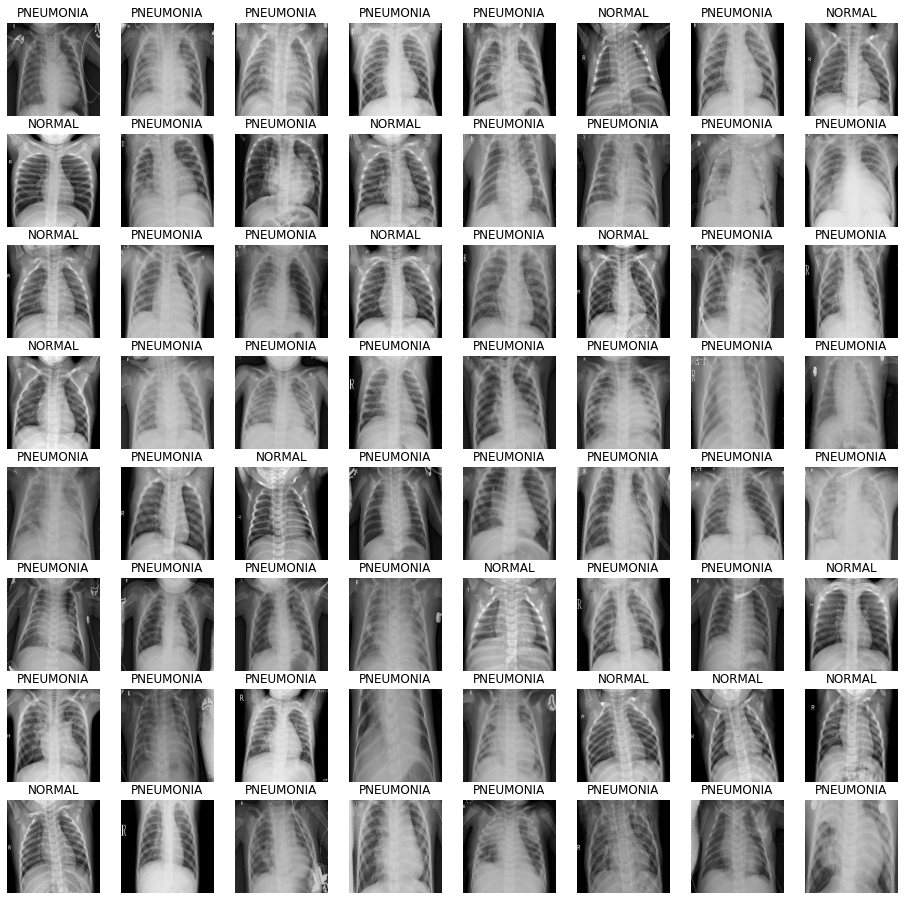

In [17]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

- 배치사이즈인 64개만큼의 데이터를 불러와 이미지와 레이블 확인

## 모델링

### 1. Convolution block 함수 만들기

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

- BatchNormalization
    - Internal Covariant Shift
        - 배치 단위의 학습 과정에서 계층 별로 입력의 데이터 분포가 달라지는 현상
        - Batch 단위로 학습을 하게 되면 Batch 단위간에 데이터 분포의 차이가 발생
    - 각 배치별로 평균과 분산을 이용해 정규화 필요 (평균은 0, 표준 편차는 1로 데이터의 분포를 조정)
    - 배치별로 정규화가 되어 overfitting 문제에 좀 더 강건해짐
    - https://gaussian37.github.io/dl-concept-batchnorm/

### 2. Dense block 함수 만들기

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 3. 모델 설계

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 데이터 imbalance 처리

- train셋의 경우, 정상데이터와 폐렴데이터 갯수가 1,070개와 3,115개로 약 3배 가량 차이가 남
- balance를 맞추지 않고 학습했을 때, 폐렴데이터가 accuracy에 주는 영향이 클 것으로 예상됨
- 정상 데이터에 가중치를 조금 더 주어 전반적인 accuracy 향상을 시도해봐야 함

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


- 정상 데이터는 1.95만큼의 가중치가 주어짐
- 폐렴 데이터는 0.67만큼의 가중치가 주어짐

## 모델 훈련

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

- tf.device('/GPU:0') : 훈련을 GPU:0을 사용하여 함
- 폐렴 진단에는 recall이 중요한 관점이므로 'recall'을 볼 수 있도록 해야함
- 분류가 정상과 폐렴 두가지밖에 없으므로 loss='binary_crossentropy'를 사용 (다중 분류는 'sparse_categorical_crossentropy'사용)

In [23]:
EPOCHS = 30
# es = EarlyStopping(monitor='val_loss', patience=3, verbose=2)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
#         callbacks=[es]
    )

Epoch 1/30
65/65 [==============================] - 62s 739ms/step - loss: 0.4635 - accuracy: 0.7519 - precision: 0.9429 - recall: 0.7095 - val_loss: 0.5923 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 47s 734ms/step - loss: 0.2255 - accuracy: 0.9058 - precision: 0.9784 - recall: 0.8931 - val_loss: 0.7102 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 49s 757ms/step - loss: 0.1571 - accuracy: 0.9425 - precision: 0.9824 - recall: 0.9395 - val_loss: 0.8512 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/30
65/65 [==============================] - 52s 814ms/step - loss: 0.1430 - accuracy: 0.9512 - precision: 0.9836 - recall: 0.9503 - val_loss: 0.9409 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/30
65/65 [==============================] - 45s 691ms/step - loss: 0.1203 - accuracy: 0.9570

## 결과 확인

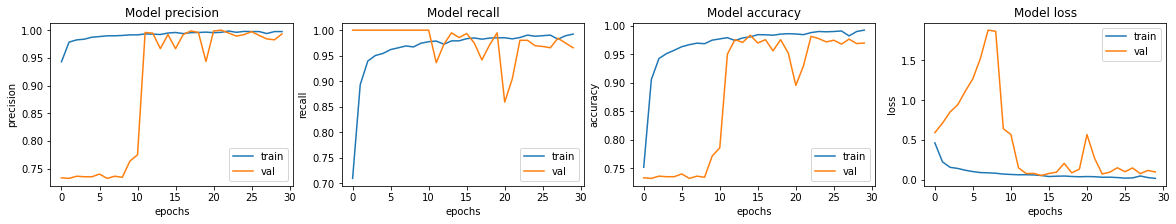

In [24]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**validation**
- recall : 변동폭이 비교적 큼
- accuracy : 95퍼센트 내외로 올라갔지만 한 번 크게 떨어졌음
- 비교적 잘 수렴함
- 랜덤으로 뽑힌 샘플이 고르게 나왔을 가능성이 있음 (이전 시도에서는 변동폭이 현재보다 크고 잦았음)

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 5s 478ms/step - loss: 1.0068 - accuracy: 0.8173 - precision: 0.7794 - recall: 0.9872
Loss: 1.0068365335464478,
Accuracy: 0.817307710647583,
Precision: 0.7793522477149963,
Recall: 0.9871794581413269


**Test**
- Recall : 0.9872
- Accuracy : **0.8173**

## augmentation 기법 활용

- 데이터에 약간의 노이즈를 추가하여 조금 더 다각화된 학습을 할 수 있음
- 좌우 반전을 추가하여 augmentation 기법을 활용할 예정

In [26]:
train_ds_ag = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_ag = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [27]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_ag(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_ag = prepare_for_training_ag(train_ds_ag)
val_ds_ag = prepare_for_training_ag(val_ds_ag)

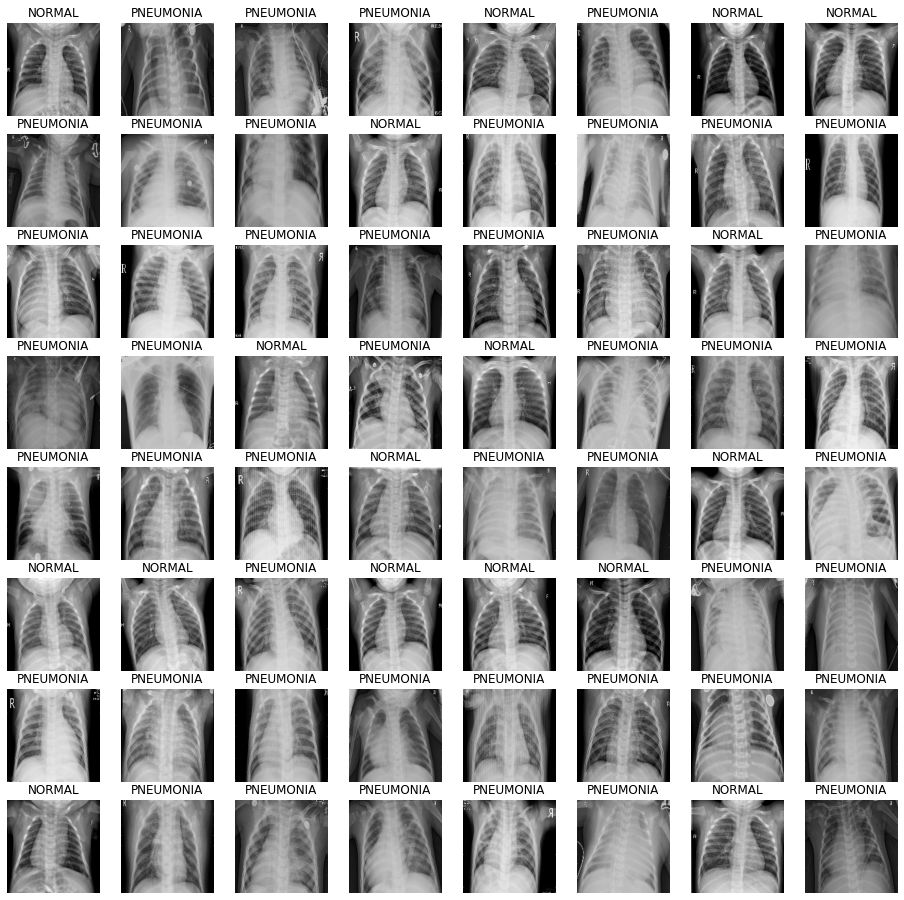

In [28]:
image_batch_ag, label_batch_ag = next(iter(train_ds_ag))
show_batch(image_batch_ag.numpy(), label_batch_ag.numpy())

- 이미지 중에 'R'이 좌우반전되어 오른쪽에 있는 이미지가 있음
- 좌우반전이 잘 이루어진 것을 확인 가능

## augmentation 기법 활용 후, 모델 적용

In [29]:
with tf.device('/GPU:0'):
    model_ag = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_ag.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history_ag = model_ag.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/30
65/65 [==============================] - 55s 719ms/step - loss: 0.4905 - accuracy: 0.7685 - precision: 0.9340 - recall: 0.7412 - val_loss: 0.5778 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 46s 713ms/step - loss: 0.2602 - accuracy: 0.8911 - precision: 0.9790 - recall: 0.8726 - val_loss: 0.7203 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 47s 730ms/step - loss: 0.1903 - accuracy: 0.9293 - precision: 0.9801 - recall: 0.9236 - val_loss: 0.9161 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/30
65/65 [==============================] - 48s 752ms/step - loss: 0.1491 - accuracy: 0.9466 - precision: 0.9822 - recall: 0.9453 - val_loss: 1.0103 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/30
65/65 [==============================] - 51s 790ms/step - loss: 0.1241 - accuracy: 0.9584

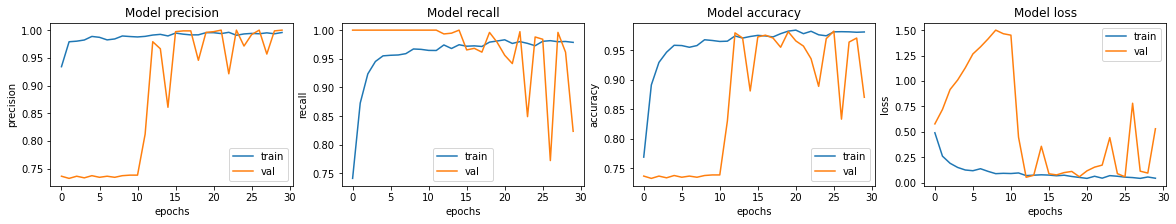

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_ag.history[met])
    ax[i].plot(history_ag.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- augmentation 기법 활용 후, validation의 precision, recall, accuracy, loss는 큰 변동폭을 보임
- 좌우반전으로 인해 이미지가 조금 더 다양해져 validation의 변화가 크게 발생한 것으로 예상됨
- validation의 항목들은 잘 수렴했다고 보기 어려움
- 랜덤으로 추출한 샘플로 인해 변동폭이 들쑥날쑥할 수 있으므로 추가적인 시도 필요

In [32]:
loss, accuracy, precision, recall = model_ag.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 407ms/step - loss: 0.6299 - accuracy: 0.8381 - precision: 0.8482 - recall: 0.9026
Loss: 0.629878044128418,
Accuracy: 0.8381410241127014,
Precision: 0.8481927514076233,
Recall: 0.9025641083717346


- augmentation 적용 후, recall은 떨어졌지만 accuracy는 올라감
    - Recall
        - 기존 : 0.9872
        - augmentation : 0.9026
    - Accuracy
        - 기존 : 0.8173
        - augmentation : **0.8381**  
- augmentation 적용으로 훈련에 다양성이 추가되어 test에도 좀 더 유연하게 적용되었을 것으로 판단됨

## 클래스별 weight없이 모델 훈련 및 평가

In [33]:
with tf.device('/GPU:0'):
    model_wgtless = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_wgtless.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [34]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history_wgtless = model_wgtless.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/30
65/65 [==============================] - 54s 703ms/step - loss: 0.5028 - accuracy: 0.7937 - precision: 0.9306 - recall: 0.7807 - val_loss: 0.5779 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 46s 712ms/step - loss: 0.2205 - accuracy: 0.9329 - precision: 0.9703 - recall: 0.9387 - val_loss: 0.7882 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 48s 743ms/step - loss: 0.1500 - accuracy: 0.9553 - precision: 0.9699 - recall: 0.9699 - val_loss: 0.9486 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 4/30
65/65 [==============================] - 49s 766ms/step - loss: 0.1305 - accuracy: 0.9611 - precision: 0.9693 - recall: 0.9787 - val_loss: 1.0009 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/30
65/65 [==============================] - 52s 805ms/step - loss: 0.1193 - accuracy: 0.9620

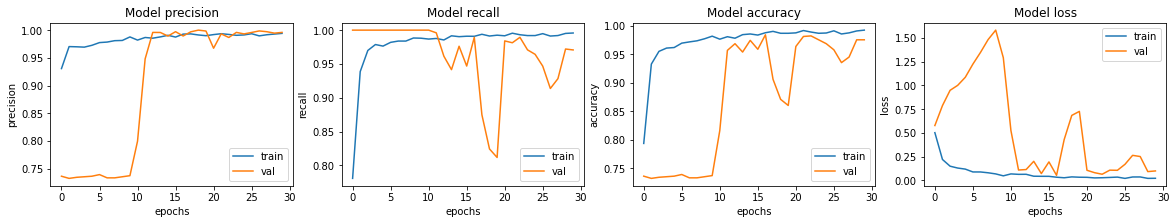

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_wgtless.history[met])
    ax[i].plot(history_wgtless.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
loss, accuracy, precision, recall = model_wgtless.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 400ms/step - loss: 1.0309 - accuracy: 0.7885 - precision: 0.7520 - recall: 0.9872
Loss: 1.0308847427368164,
Accuracy: 0.7884615659713745,
Precision: 0.751953125,
Recall: 0.9871794581413269


- Accuracy는 class별 weight를 제외한 경우, 약 0.03정도 떨어짐
- Recall은 거의 비슷한 수준을 보임

## 클래스별 weight없이 모델 훈련 및 평가 (augmentation 활용)

In [37]:
with tf.device('/GPU:0'):
    model_ag_wgtless = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_ag_wgtless.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [38]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history_ag_wgtless = model_ag_wgtless.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE
    )

Epoch 1/30
65/65 [==============================] - 54s 693ms/step - loss: 0.5285 - accuracy: 0.7575 - precision: 0.9267 - recall: 0.7317 - val_loss: 0.5769 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 46s 712ms/step - loss: 0.2469 - accuracy: 0.9185 - precision: 0.9615 - recall: 0.9276 - val_loss: 0.7377 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 48s 741ms/step - loss: 0.1639 - accuracy: 0.9464 - precision: 0.9684 - recall: 0.9593 - val_loss: 0.8964 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/30
65/65 [==============================] - 49s 758ms/step - loss: 0.1426 - accuracy: 0.9524 - precision: 0.9683 - recall: 0.9676 - val_loss: 0.9464 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/30
65/65 [==============================] - 52s 805ms/step - loss: 0.1376 - accuracy: 0.9546

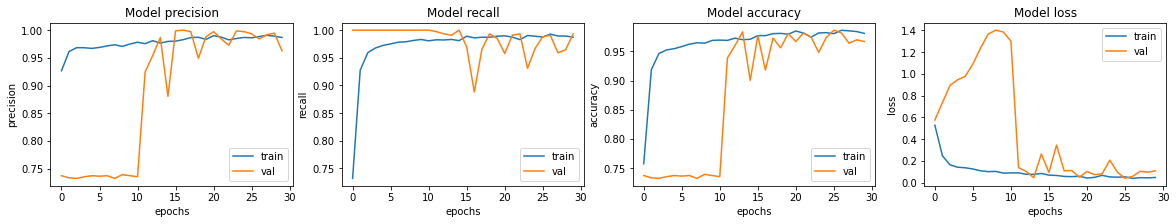

In [39]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_ag_wgtless.history[met])
    ax[i].plot(history_ag_wgtless.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [40]:
loss, accuracy, precision, recall = model_ag_wgtless.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 401ms/step - loss: 1.7656 - accuracy: 0.6875 - precision: 0.6672 - recall: 0.9974
Loss: 1.765639305114746,
Accuracy: 0.6875,
Precision: 0.6672384142875671,
Recall: 0.9974358677864075


- augmentation 활용한 것으로 비교했을 경우
    - Accuracy는 class별 weight를 제외한 경우, 약 0.15 떨어짐
    - Recall의 경우, 약 0.095 올라감

## dropout없이 모델 훈련 및 평가 (augmentation 활용)

In [41]:
def dense_block_nodropout(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [42]:
def build_model_nodropout():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block_nodropout(512),
        dense_block_nodropout(128),
        dense_block_nodropout(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [43]:
with tf.device('/GPU:0'):
    model_ag_nodropout = build_model_nodropout()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_ag_nodropout.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [44]:
EPOCHS = 30

with tf.device('/GPU:0'):
    history_ag_nodropout = model_ag_nodropout.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/30
65/65 [==============================] - 57s 740ms/step - loss: 0.2079 - accuracy: 0.9118 - precision: 0.9789 - recall: 0.9006 - val_loss: 0.5761 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/30
65/65 [==============================] - 47s 728ms/step - loss: 0.1175 - accuracy: 0.9553 - precision: 0.9857 - recall: 0.9539 - val_loss: 0.6125 - val_accuracy: 0.7422 - val_precision: 0.7422 - val_recall: 1.0000
Epoch 3/30
65/65 [==============================] - 48s 740ms/step - loss: 0.0929 - accuracy: 0.9688 - precision: 0.9891 - recall: 0.9686 - val_loss: 0.7267 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/30
65/65 [==============================] - 49s 764ms/step - loss: 0.0809 - accuracy: 0.9702 - precision: 0.9905 - recall: 0.9694 - val_loss: 0.8273 - val_accuracy: 0.7412 - val_precision: 0.7412 - val_recall: 1.0000
Epoch 5/30
65/65 [==============================] - 50s 784ms/step - loss: 0.0774 - accuracy: 0.9721

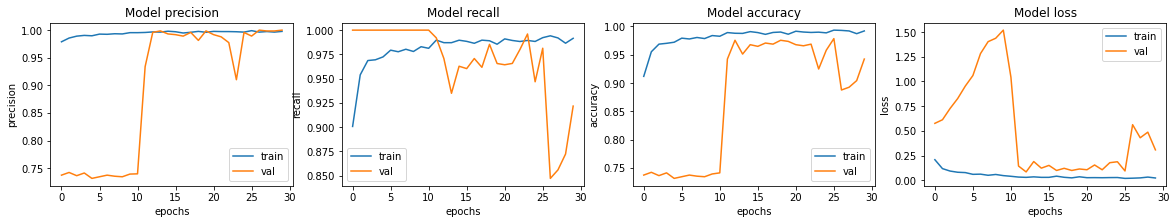

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_ag_nodropout.history[met])
    ax[i].plot(history_ag_nodropout.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

- dropout을 제외한 경우, recall이 epoch26을 지나면서 큰 폭으로 떨어짐

In [46]:
loss, accuracy, precision, recall = model_ag_nodropout.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 429ms/step - loss: 0.5560 - accuracy: 0.8654 - precision: 0.8446 - recall: 0.9615
Loss: 0.5560469627380371,
Accuracy: 0.8653846383094788,
Precision: 0.8445945978164673,
Recall: 0.9615384340286255


- augmentation을 적용하고 dropout을 제외했을 때, Accuracy는 **0.8654**로 측정됨

## learning rate, batchsize, epoch 조정 (augmentation 활용)

In [47]:
BATCH_SIZE = 128
EPOCHS = 60
lr = 0.0001

In [48]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [49]:
train_ds_ag = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_ag = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [50]:
train_ds_ag = prepare_for_training_ag(train_ds_ag)
val_ds_ag = prepare_for_training_ag(val_ds_ag)

In [51]:
with tf.device('/GPU:0'):
    model_ag = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_ag.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [52]:
with tf.device('/GPU:0'):
    history_ag = model_ag.fit(
        train_ds_ag,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_ag,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight
    )

Epoch 1/60
32/32 [==============================] - 58s 1s/step - loss: 0.5844 - accuracy: 0.6951 - precision: 0.9130 - recall: 0.6530 - val_loss: 0.6960 - val_accuracy: 0.2627 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
32/32 [==============================] - 47s 2s/step - loss: 0.4153 - accuracy: 0.7920 - precision: 0.9712 - recall: 0.7419 - val_loss: 0.6939 - val_accuracy: 0.2607 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
32/32 [==============================] - 49s 2s/step - loss: 0.3649 - accuracy: 0.8232 - precision: 0.9778 - recall: 0.7801 - val_loss: 0.6907 - val_accuracy: 0.7373 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/60
32/32 [==============================] - 51s 2s/step - loss: 0.3221 - accuracy: 0.8508 - precision: 0.9837 - recall: 0.8130 - val_loss: 0.6883 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 5/60
32/32 [==============================] - 45s 1s/step - loss: 0.2754 - accuracy: 0.879

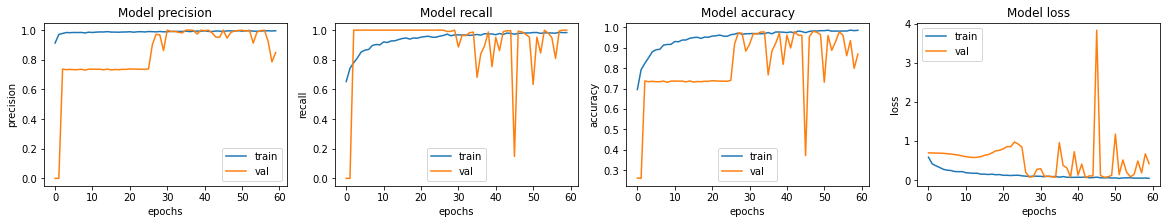

In [53]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_ag.history[met])
    ax[i].plot(history_ag.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [54]:
loss, accuracy, precision, recall = model_ag.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

5/5 [==============================] - 5s 1s/step - loss: 1.5862 - accuracy: 0.6346 - precision: 0.6311 - recall: 1.0000
Loss: 1.5861785411834717,
Accuracy: 0.6346153616905212,
Precision: 0.6310679316520691,
Recall: 1.0


## Learning_rate, Batch_size, epochs 조정

**해당 내용은 본 노트북 파일이 너무 길어질 것을 우려하여 다른 노트북 파일에서 실험한 후에 결과만 가져옴**

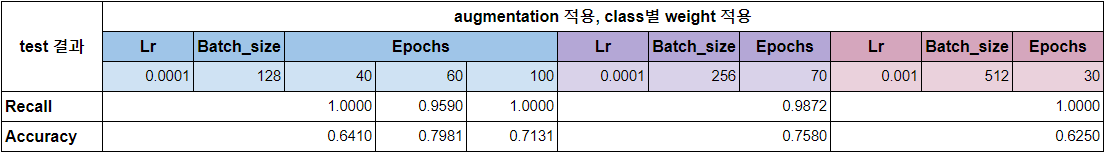

- 이번 exploration에서는 hyper parameter 조정으로 인한 유의미한 결론은 얻어내지 못함
- 같은 세팅 내에서도 시도할 때마다 매우 다른 Accuracy가 나왔었음

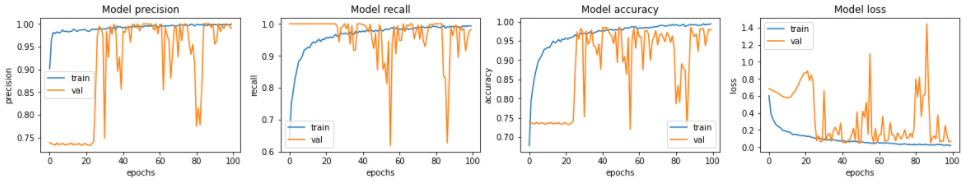

- epochs를 100으로 두어 일부러 overfitting을 만들어내고 싶었지만 overfitting 시점을 제대로 파악하기 어려웠음
- epochs를 더 늘리는건 시간상 문제로 pass

## 결론

### 1. ablation study

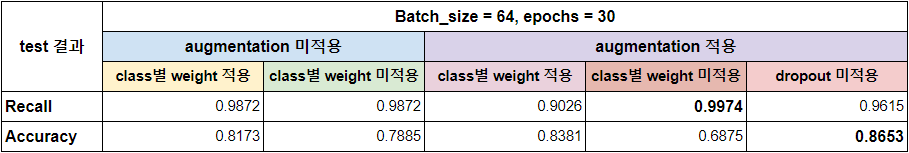

- Accuracy
    - augmentation을 적용하고 dropout을 미적용했을 때, test Accuracy가 가장 높게 측정됨
    - **0.8653**
<br><br>
- Recall
    - augmentation을 적용하고 class별 weight를 미적용했을 때, test Recall이 가장 높게 측정됨
    - **0.9974**
    - 하지만 이 경우의 Accuracy는 0.6875로 현저히 낮게 측정됨
<br><br>    
- 실제로 활용할 경우
    - augmentation을 미적용하고 class별 weight를 적용했을 때를 활용해야한다고 생각함
    - Recall과 Accuracy 모두 성능이 비교적 높게 나왔기 때문
    - 의학적 상황에서 1종 오류에 해당할 때 더 치명적인 상황이 발생되므로 **recall적 관점을 중요시 해야함**  
        (폐렴환자라고 진단하지 않았지만 실제 폐렴환자일 경우, 매우 심각한 상황 발생)

### 2. validation 수렴

**augmentation 미적용, class별 weight 적용 했을 때**
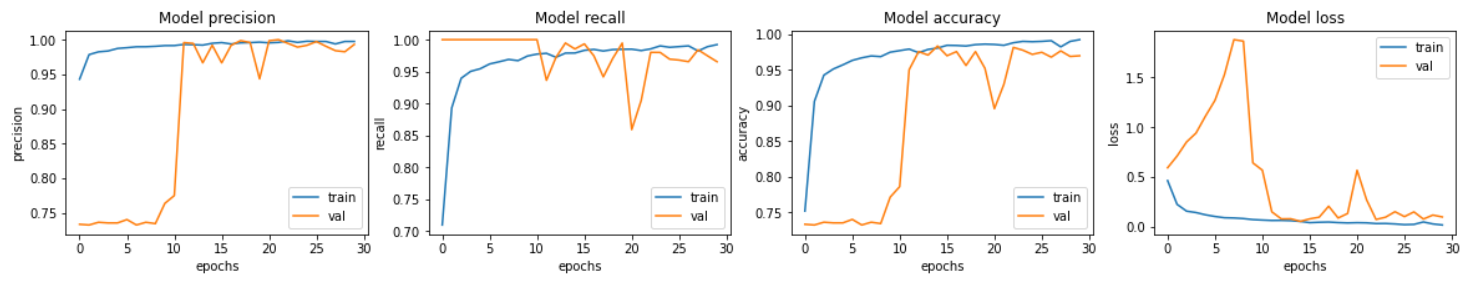

**augmentation 적용, class별 weight 미적용 했을 때**
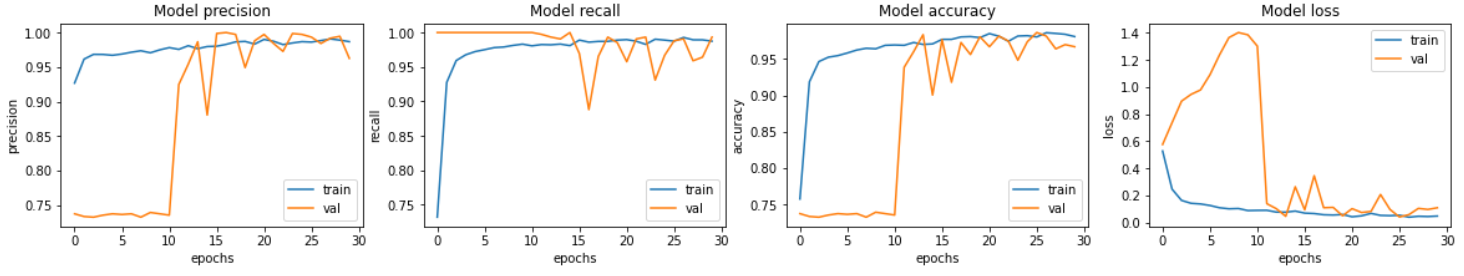

- 위의 두 경우가 validation의 각 항목들이 비교적 잘 수렴했다고 볼 수 있음
- 하지만 훈련에 필요한 랜덤 추출된 샘플에 따라 영향력이 클 것으로 예상됨 

## 회고

### 1. 새로 알아갔던 점
 - 데이터의 레이블이 imbalance한 경우 class별 weight를 주어 loss에 영향을 다르게 준다는 점
 - augmentation 기법으로 이미지에 변화를 준다는 점 (이미지 다양성 확보)

### 2. 흥미로웠던 점
 - 의학적 데이터를 딥러닝을 통해 진단하는 점이 흥미로웠음
 - 의학적 데이터를 다룰 때, augmentation을 적용하는 것을 조심스럽게 해야한다는 점
 - recall의 관점을 다시 되뇌이면서 결과를 확인했던게 흥미로웠음

### 3. 아쉬웠던 점
 - 몇몇 x-ray 이미지는 폐렴환자인지 정상인지 구분하기 어려웠음
 - 의학적 지식이 있다면 조금 더 deep하게 접근해볼 수 있었을 것 같음
 - x-ray 이미지 수가 비교적 적었다고 생각됨

### 4. 앞으로의 다짐
 - augmentation 기법 활용을 좀 더 다양하게 해보려 함